In [1]:
import pandas as pd
import cv2
import matplotlib.pyplot as plt
import glob
import numpy as np
import seaborn as sns
import os
from PIL import Image

/var/folders/5m/c9lk_h8j0tx9wf017kg3733m0000gn/T/ipykernel_27055/3460533238.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [3]:
def get_paths(data_path):

    masks_paths = sorted(glob.glob(f"{data_path}/masks/*"))
    image_paths = sorted(glob.glob(f"{data_path}/cropped_frames/*"))
    return masks_paths, image_paths

In [4]:
def extract_roi(masks, bottom=450):

    center = masks.shape[-1] // 2

    bottom_left = masks[:, bottom:, :center]
    bottom_right = masks[:, bottom:, center:]
    upper_left = masks[:, :bottom, :center]
    upper_right = masks[:, :bottom, center:]

    return bottom_left, bottom_right, upper_left, upper_right


def get_area(masks):
    return np.sum(masks, axis=(1, 2))

In [141]:
def plot_area(ax, area_right, area_left, color):

    plt.rcParams["figure.frameon"] = False
    cmap = plt.get_cmap("viridis")
    ax.spines["right"].set_visible(False)
    ax.spines["top"].set_visible(False)

    ax.plot(area_right, color=color, alpha=1)
    ax.plot(area_left, color="grey", alpha=1, linestyle="dashed")
    ax.set_ylim(-0.1, 0.7)
    ax.set_xlabel(r"Time (minutes)")
    ax.set_ylabel(r"Relative area")
    sns.despine(
        trim=True,
    )
    # plt.legend()
    return ax

In [439]:
def overlay_segmentation_cv(ind, image_paths, masks, color, alpha=0.4):
    image = cv2.imread(image_paths[ind])
    print(image_paths[ind])
    mask = masks[ind]
    overlay = np.zeros_like(image)
    overlay[mask > 0] = color
    cv2.addWeighted(overlay, alpha, image, 1 - alpha, 0, image)

    return image

In [143]:
def get_results(data_path):
    masks_paths, image_paths = get_paths(data_path)
    masks = np.array([np.load(i) for i in masks_paths])
    print(masks.shape)
    bottom_left, bottom_right, upper_left, upper_right = extract_roi(masks)

    print(f"Number of masks: {len(masks_paths)}, Number of images: {len(image_paths)}")
    assert len(masks_paths) == len(image_paths)

    area_bottom_left = get_area(bottom_left)
    area_bottom_right = get_area(bottom_right)
    area_upper_left = get_area(upper_left)
    area_upper_right = get_area(upper_right)

    area_right = area_upper_right / (area_upper_right + area_bottom_right)
    area_left = area_upper_left / (area_upper_left + area_bottom_left)

    return area_right, area_left, image_paths, masks

In [393]:
import matplotlib.colors as mcolors


def hex_to_bgr(hex_color):
    """Convert a hexadecimal color string to a BGR tuple."""
    hex_color = hex_color.lstrip("#")  # Remove '#' if present
    lv = len(hex_color)
    return tuple(int(hex_color[i : i + lv // 3], 16) for i in range(0, lv, lv // 3))[
        ::-1
    ]


def convert_to_bgr(color):
    # Use Matplotlib's CSS4_COLORS dictionary
    css4_colors = mcolors.CSS4_COLORS

    if isinstance(color, str):  # Handle named color
        # Convert the named color to hexadecimal and then to BGR
        hex_color = css4_colors.get(color.lower())
        if hex_color:
            bgr = hex_to_bgr(hex_color)
        else:
            print(f"Named color '{color}' is not in the Matplotlib CSS4_COLORS list.")
    elif isinstance(color, tuple) and len(color) == 4:  # Handle RGBA tuple
        # Convert RGBA to BGR (ignore alpha channel)
        bgr = (int(color[2] * 255), int(color[1] * 255), int(color[0] * 255))
    else:
        print(f"Input '{color}' is not recognized as a valid color format.")

    return bgr

In [144]:
results = {}
for path in glob.glob("data/*_video_*"):
    print(path)
    results[path.split("/")[-1]] = get_results(path)

data/ant_video_1
(118, 710, 1100)
Number of masks: 118, Number of images: 118
data/ant_video_4
(123, 710, 1100)
Number of masks: 123, Number of images: 123
data/ant_video_3
(123, 710, 1100)
Number of masks: 123, Number of images: 123
data/ant_video_2
(122, 710, 1100)
Number of masks: 122, Number of images: 122
data/ant_video_5
(61, 710, 1100)
Number of masks: 61, Number of images: 61


In [145]:
custom_order = [
    "ant_video_4",
    "ant_video_5",
    "ant_video_1",
    "ant_video_2",
    "ant_video_3",
]
results_sorted = {
    k: results[k] for k in sorted(results, key=lambda k: custom_order.index(k))
}

In [381]:
colors = ["purple", "cyan", "darkorange", "darkblue", "salmon"]
os.m

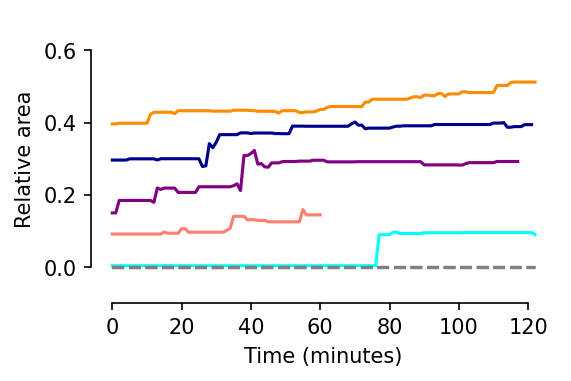

In [414]:
fig = plt.figure(figsize=(4, 2.5), dpi=150)
ax = fig.add_subplot(111)
video_to_colors = {}
for i, (key, values) in enumerate(results.items()):
    plot_area(ax, values[0], values[1], color=colors[i])
    video_to_colors[key] = convert_to_bgr(colors[i])
fig.savefig("plots/all_together.png", dpi=150, bbox_inches="tight")

In [418]:
# ax = plt.figure(figsize=(4, 2.5), dpi = 150).add_subplot(111)
# ax.plot(np.arange(10), color='black',label='CCAP')
# ax.plot(np.arange(10), color='black',label='scram', linestyle = 'dashed')
# plt.legend()
# plt.savefig('plots/all_together_labels.png', dpi = 500)

In [417]:
# fig = plt.figure(figsize=(4, 2.5), dpi = 150)
# ax = fig.add_subplot(111)
# for i, (key, values) in enumerate(results.items()):
#     ax.plot([0,0,0,0,0,0,0,0,0,0,0,0,3], color = colors[i], label = key)
# plt.legend(loc='upper left')
# fig.savefig('plots/all_together_labels_all.png', bbox_inches='tight', )

In [429]:
for key in results.keys():
    image_paths = results[key][2]
    masks = results[key][3]
    for ind in [0, len(image_paths) - 1]:
        image_mask = overlay_segmentation_cv(
            ind, image_paths, masks, color=video_to_colors[key], alpha=0.5
        )
        cv2.imwrite(f"plots/{key}_{ind}.png", image_mask)